# Modern portfolio theory of H. Markowitz

Modern portfolio theory is a practical method of selecting investments to maximise their overall return within an acceptable level of risk. This mathematical framework is used to construct a portfolio of investments that maximises the amount of expected return for a given level of collective risk — portfolio risk.

A key element of the LMP is diversification. Most investments are either high risk/high return or low risk/low return. According to Markowitz, investors can achieve the best results by choosing an optimal combination of these two types of investments based on an assessment of their individual risk tolerance.

In portfolio optimization we have some amount of money to invest in any of $n$ different assets. <br>
We choose what fraction $w_i$ of our money to invest in each asset $i$, $i=1, \ldots, n$.<br>
We call $w\in {\bf R}^n$ the **_portfolio allocation vector_**.<br>
We of course have the constraint that ${\mathbf 1}^T w =1$.
The allocation $w_i<0$ means a **short position** in asset $i$, or that we borrow shares to sell now that we must replace later.
The allocation $w \geq 0$ is a _long only_ portfolio.
The quantity
$$ \|w \|_1 = {\mathbf 1}^T w_+ + {\mathbf 1}^T w\_- $$
is known as _leverage_.

- Expected return: $$\mathbb{E}(r_p)=w^T\space \mathbb{E}(r) = \sum^{n}_{i=1}w_i\mathbb{E}(r_i)$$
- Risk (Annualized volatility $\sigma$ ) : $$\sigma^2_p=\sum^{n}_{i=1}\sum^{n}_{j=1}w_i\times w_j\times cov(r_i,r_j)$$
- The Sharpe Ratio from the CAPM: $$S_p=\frac{\mathbb{E}(r_p-r_f)}{\sigma_p}\space\text{basically}\space S_p=\frac{\mathbb{E}(r_p)-r_{f_{annualized}}}{\sigma_p}$$


In [1]:
from warnings import filterwarnings

filterwarnings("ignore")
from datetime import datetime
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from modules.data_fetcher import (
    download_historical_data,
    get_list_of_symbols,
    build_close_df,
)

from modules.portfolio_optimization import MonteCarloPortfolio

In [2]:
MININUM_HISTORY_YEAR = 2
N = 365
# get_list_of_symbols()
symbols = set(
    [
        "ROSE-USDT",
        "AVAX-USDT",
        "UNI-USDT",
        "ATOM-USDT",
        "ICP-USDT",
        "THETA-USDT",
        "VET-USDT",
        "DOGE3S-USDT",
        "BNB-USDT",
        "NEAR-BTC",
        "BTC-USDT",
        "NEAR-USDT",
        "SOLVE-BTC",
        "ETH-USDT",
        "KDA-USDT",
        "SOL-USDT",
        "EGLD-USDT",
        "ALGO-USDT",
        "FTM-USDT",
        "AXS-USDT",
        "ADA-USDT",
        "NKN-USDT",
        "LOOM-BTC",
        "CUSD-USDT",
        "LTC3L-USDT",
        "XPR-USDT",
    ]
)


closes = build_close_df(symbols)

cols_to_remove = [
    col
    for col, nans in closes.isna().sum().items()
    if len(closes) - nans < N * MININUM_HISTORY_YEAR
]


closes.drop(columns=cols_to_remove, inplace=True)
returns = closes.pct_change().dropna()
log_returns = np.log(closes).pct_change().dropna()
returns.head()

AVAX-USDT
THETA-USDT
NEAR-USDT
EGLD-USDT
LOOM-BTC
ICP-USDT
ALGO-USDT
FTM-USDT
UNI-USDT
NKN-USDT
CUSD-USDT
SOLVE-BTC
DOGE3S-USDT
AXS-USDT
LTC3L-USDT
KDA-USDT
ADA-USDT
NEAR-BTC
BNB-USDT
ATOM-USDT
VET-USDT
BTC-USDT
ETH-USDT
XPR-USDT
ROSE-USDT
SOL-USDT


,AVAX-USDT_Close,THETA-USDT_Close,LOOM-BTC_Close,ALGO-USDT_Close,FTM-USDT_Close,UNI-USDT_Close,SOLVE-BTC_Close,ADA-USDT_Close,BNB-USDT_Close,ATOM-USDT_Close,VET-USDT_Close,BTC-USDT_Close,ETH-USDT_Close,ROSE-USDT_Close
Date,,,,,,,,,,,,,,
2021-03-18,0.015400,0.071096,0.210909,-0.024277,-0.066114,-0.041741,0.285714,-0.110428,-0.031226,0.056637,0.011595,-0.020839,-0.025642,-0.113455
2021-03-19,0.123951,-0.022681,-0.063063,-0.007790,0.039372,0.110345,0.000000,0.053323,0.006515,0.005138,0.043658,0.006510,0.018789,-0.035220
2021-03-20,-0.084177,0.012084,-0.019231,-0.032927,0.030256,-0.039371,-0.146538,-0.072942,0.004986,-0.059096,0.105900,0.001539,-0.001780,-0.002097
2021-03-21,-0.042039,0.151563,0.006536,-0.021953,-0.000211,0.026449,0.056604,-0.011763,0.001433,-0.018490,0.046807,-0.013135,-0.012690,0.167348
2021-03-22,-0.107483,0.044366,0.061688,-0.066576,-0.074746,-0.000113,-0.028571,-0.071503,-0.036593,-0.065317,-0.057433,-0.056741,-0.057339,-0.136010


100%|██████████| 20000/20000 [00:32<00:00, 623.07it/s]


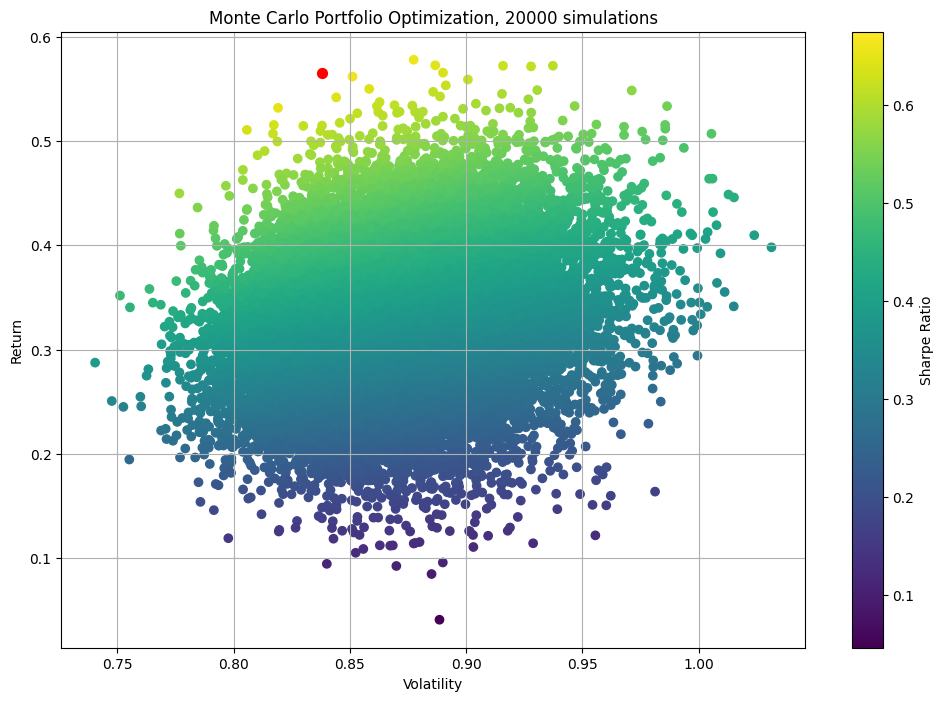

In [3]:
portfolio = MonteCarloPortfolio(returns)


portfolio.fit(n_portfolios=20000, trading_days=365, plot=True)

--------------  Results  ---------------
- Annualized Sharpe ratio: 0.67
- Annualized risk (volatility): 83.81 %
- Annualized expected return: 56.53 %


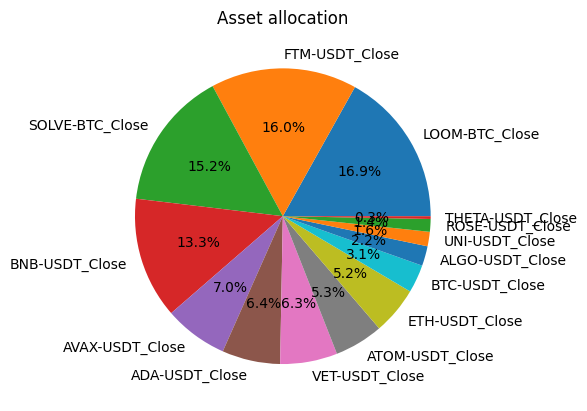

,AVAX-USDT_Close,THETA-USDT_Close,LOOM-BTC_Close,ALGO-USDT_Close,FTM-USDT_Close,UNI-USDT_Close,SOLVE-BTC_Close,ADA-USDT_Close,BNB-USDT_Close,ATOM-USDT_Close,VET-USDT_Close,BTC-USDT_Close,ETH-USDT_Close,ROSE-USDT_Close
0,0.069675,0.003007,0.168924,0.021594,0.159876,0.015778,0.152305,0.063619,0.132688,0.053305,0.062559,0.030681,0.052109,0.013881


In [4]:
portfolio.get_allocation("sharpe","max",True, True)

# Other Optimization process


In [5]:
def get_ret_vol_sr(weights):  # Cost function
    weights = np.array(weights)
    weighted_returns_vect = (returns * weights).sum(axis=1)
    ret = np.sum(returns.mean() * weights * N)
    ret_mediam = np.sum(returns.median() * weights * N)
    vol = np.sqrt(weights.T @ returns.cov() * N @ weights)
    sr = ret / vol
    sr_med = ret / vol
    return np.array([ret, vol, sr, ret_mediam, sr_med])


def neg_sharpe(weights):
    return -get_ret_vol_sr(weights)[2]


def check_sum(weights):
    # return 0 if sum of the weights is 1
    return np.sum(weights) - 1


min_number_of_assets = 7


def number_of_weighted_asset(weights):
    len_of_weights = len(weights)
    len_of_null_weights = len([w for w in weights if w < 0.01])
    not_null_weights = len_of_weights - len_of_null_weights
    return not_null_weights - min_number_of_assets


cons = tuple(
    [
        {"type": "eq", "fun": check_sum},
    ]  # {"type": "ineq", "fun": number_of_weighted_asset}
)

bounds = tuple([(0, 0.3) for _ in range(len(returns.columns))])
init_guess = [1 / len(returns.columns) for _ in range(len(returns.columns))]

opt_results = minimize(
    neg_sharpe, init_guess, method="SLSQP", bounds=bounds, constraints=cons
)
print(
    f"Return: {get_ret_vol_sr(opt_results.x)[0]:.2f}\nVolatility: {get_ret_vol_sr(opt_results.x)[1]:.2f}\nSharpe-ratio: {get_ret_vol_sr(opt_results.x)[2]:.2f}"
)

res = [(p, float(w)) for p, w in zip(closes.columns, opt_results.x)]
res.sort(key=lambda x: x[1], reverse=True)
res = np.array(res)
res

Return: 0.78
Volatility: 0.87
Sharpe-ratio: 0.90


array([['FTM-USDT_Close', '0.3'],
       ['LOOM-BTC_Close', '0.28421690178232134'],
       ['BNB-USDT_Close', '0.2662126066894555'],
       ['SOLVE-BTC_Close', '0.11294322872529149'],
       ['ETH-USDT_Close', '0.036627262802931396'],
       ['UNI-USDT_Close', '9.142700323985298e-16'],
       ['ALGO-USDT_Close', '1.9243559021005343e-16'],
       ['VET-USDT_Close', '1.6375126709316946e-17'],
       ['AVAX-USDT_Close', '8.168439305341662e-18'],
       ['ADA-USDT_Close', '0.0'],
       ['THETA-USDT_Close', '0.0'],
       ['BTC-USDT_Close', '0.0'],
       ['ROSE-USDT_Close', '0.0'],
       ['ATOM-USDT_Close', '0.0']], dtype='<U32')

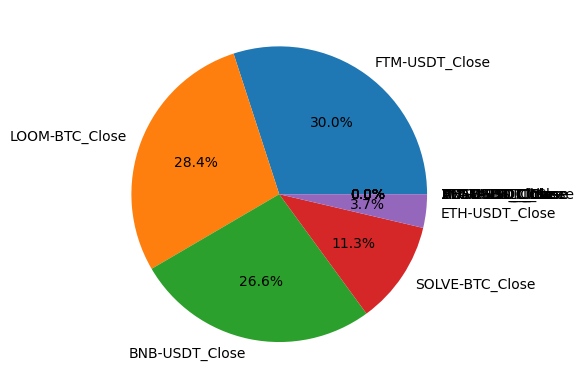

In [6]:
plt.pie(res[:, -1], labels=res[:, 0], autopct="%1.1f%%")
plt.show()

# Using Riskfolio


In [7]:
import riskfolio as rp

port = rp.Portfolio(returns=returns)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu = "hist"  # Method to estimate expected returns based on historical data.
method_cov = "hist"  # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model = "Classic"  # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = "MV"  # Risk measure used, this time will be variance
obj = "Sharpe"  # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True  # Use historical scenarios for risk measures that depend on scenarios
rf = 0  # Risk free rate
l = 0  # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,VET-USDT_Close,ETH-USDT_Close,ALGO-USDT_Close,ADA-USDT_Close,UNI-USDT_Close,THETA-USDT_Close,FTM-USDT_Close,BTC-USDT_Close,ROSE-USDT_Close,ATOM-USDT_Close,LOOM-BTC_Close,SOLVE-BTC_Close,BNB-USDT_Close,AVAX-USDT_Close
weights,4.651171e-10,4.432329e-09,2.870293e-10,3.979719e-10,3.310225e-10,2.763627e-10,0.594748,5.614166e-10,7.061832e-10,1.290747e-09,0.284279,0.120973,6.053708e-08,1.447528e-09


<Axes: title={'center': 'Sharpe Mean Variance'}>

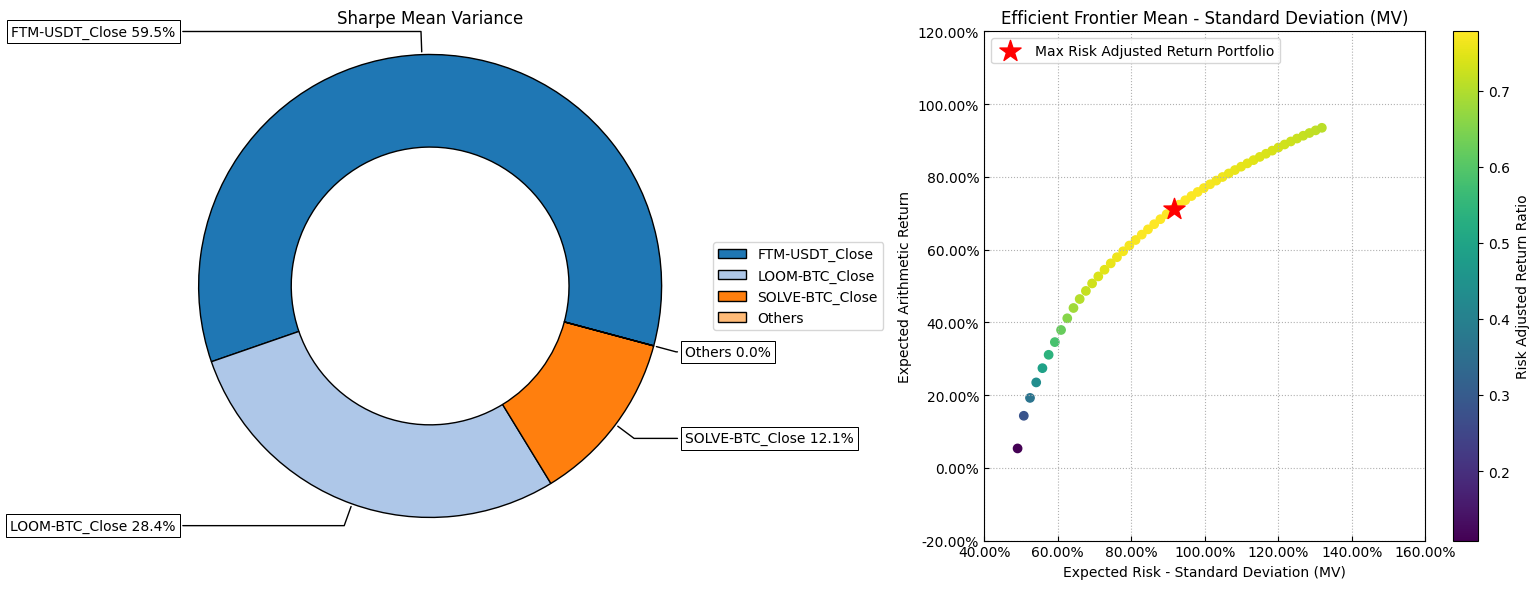

In [9]:
points = 50  # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)


label = "Max Risk Adjusted Return Portfolio"  # Title of point
mu = port.mu  # Expected returns
cov = port.cov  # Covariance matrix
returns = port.returns  # Returns of the assets

figure, ax = plt.subplots(1, 2, figsize=(15, 6))


rp.plot_frontier(
    w_frontier=frontier,
    mu=mu,
    cov=cov,
    returns=returns,
    rm=rm,
    rf=rf,
    alpha=0.05,
    cmap="viridis",
    w=w,
    label=label,
    marker="*",
    s=16,
    c="r",
    height=6,
    width=10,
    ax=ax[1],
)


rp.plot_pie(
    w=w,
    title="Sharpe Mean Variance",
    others=0.05,
    nrow=25,
    cmap="tab20",
    height=6,
    width=10,
    ax=ax[0],
)

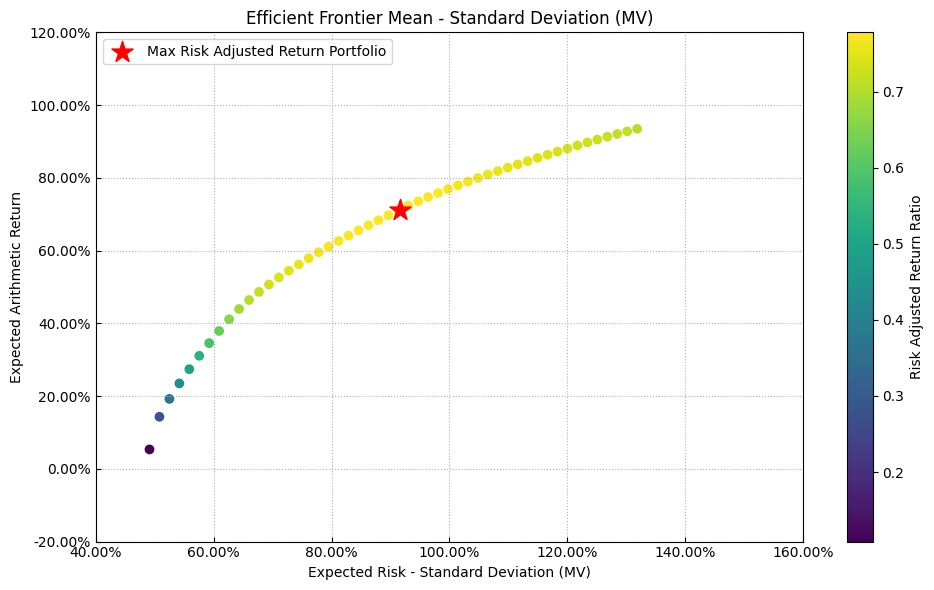

In [51]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.
rms = [
    "MV",
    "MAD",
    "MSV",
    "FLPM",
    "SLPM",
    "CVaR",
    "EVaR",
    "WR",
    "MDD",
    "ADD",
    "CDaR",
    "UCI",
    "EDaR",
]

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)

w_s.columns = rms


def filter_unused(x: pd.Series):
    for i in x:
        if i >= 1e-3:
            return True
    return False


w_s = w_s.loc[w_s.apply(filter_unused, axis=1)]
w_s.style.format("{:.2%}").background_gradient(cmap="YlGn")

Failure:interrupted
The problem doesn't have a solution with actual input parameters


## Comparing each portfolio


<Axes: >

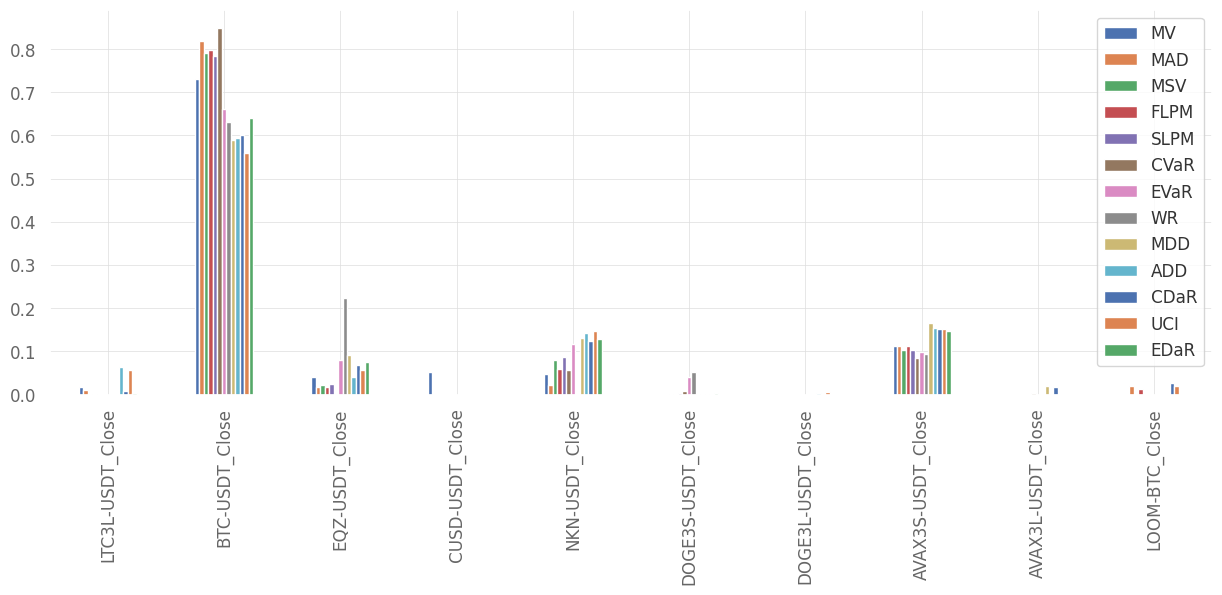

In [ ]:
fig = plt.gcf()
fig.set_figwidth(15)
fig.set_figheight(5)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)

In [ ]:
# Using empyrical


In [ ]:
from empyrial import empyrial, Engine

portfolio = Engine(
    start_date="2018-01-01",  # start date for the backtesting
    portfolio=[
        "IRCTC.NS",
        "RELIANCE.NS",
        "INFY.NS",
        "HDFCBANK.NS",
    ],  # assets in your portfolio
    weights=[0.2, 0.2, 0.2, 0.2],  # equal weighting is set by default
    benchmark=["^NSEI"],  # SPY is set by default
)

empyrial(portfolio)